Link: | https://www.kaggle.com/c/fake-news

## Aim is to develop a machine learning program to identify when an article might be fake news. 

Run by the UTK Machine Learning Club.

## Evaluation Metric
The evaluation metric for this competition is accuracy, a very straightforward metric.

\[ accuracy = \frac{correct\ predictions}{correct\ predictions+incorrect\ predictions}\]

Accuracy measures false positives and false negeatives equally, and really should only be used in simple cases and when classes are of generally equal class size

## Data Description

train.csv: A full training dataset with the following attributes:

id: unique id for a news article
title: the title of a news article
author: author of the news article
text: the text of the article; could be incomplete
label: a label that marks the article as potentially unreliable

1: unreliable

0: reliable

test.csv: A testing training dataset with all the same attributes at train.csv without the label.

submit.csv: A sample submission

In [1]:
#If you get 403 - Forbidden
#First try by accepting competition rules in Kaggle portal. Also Kaggle login mail-id & Colab mail-id should be same

In [2]:
#!pip install kaggle --quiet

!pip install --upgrade --force-reinstall --no-deps kaggle --quiet
#Use the above command if you get: Looks like you're using an outdated API Version, please consider updating

     |████████████████████████████████| 61kB 6.6MB/s 


In [3]:
#Make a directory for Kaggle
!mkdir /content/.kaggle

In [4]:
#Connect Google drive to colab
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
#Copy kaggle.json file. Change gdrive folder based on where you have saved your json file from Kaggle
!cp '/gdrive/My Drive/kaggle/kaggle.json' /content/.kaggle/kaggle.json

In [6]:
#Check if json file is there
!ls -l /content/.kaggle

total 4
-rw------- 1 root root 68 Apr 11 12:23 kaggle.json


In [7]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [8]:
!kaggle -v

Kaggle API 1.5.12


In [9]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-11 07:33:11           2433        254  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1410        151  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1055        109  1.0              
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020

In [10]:
!kaggle competitions download -c fake-news -p /content

 88% 41.0M/46.5M [00:00<00:00, 64.1MB/s]
100% 46.5M/46.5M [00:00<00:00, 111MB/s] 


In [11]:
#Confirm data has been downloaded
!ls -l

ls: cannot access 'drive': Transport endpoint is not connected
total 47588
d????????? ? ?    ?           ?            ? drive
-rw-r--r-- 1 root root 48725919 Apr 11 12:23 fake-news.zip
drwxr-xr-x 1 root root     4096 Apr  7 13:36 sample_data


In [12]:
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [13]:
!ls -l

ls: cannot access 'drive': Transport endpoint is not connected
total 168508
d????????? ? ?    ?           ?            ? drive
-rw-r--r-- 1 root root 48725919 Apr 11 12:23 fake-news.zip
drwxr-xr-x 1 root root     4096 Apr  7 13:36 sample_data
-rw-r--r-- 1 root root    41609 Nov 29  2019 submit.csv
-rw-r--r-- 1 root root 25144581 Nov 29  2019 test.csv
-rw-r--r-- 1 root root 98628550 Nov 29  2019 train.csv


In [14]:
import tensorflow as tf
print (tf.__version__)

2.4.1


In [78]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [16]:
import numpy as np
import pandas as pd

data = pd.read_csv('train.csv')
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [17]:
data=data.dropna()

In [18]:
#Creating the Features set
X=data.drop('label',axis=1)
y=data['label']

In [19]:
X.shape

(18285, 4)

In [20]:
y.shape

(18285,)

In [21]:
### Vocabulary size
voc_size=10000

In [22]:
messages=X.copy()
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [23]:
messages['text'][1]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

In [24]:
messages.reset_index(inplace=True)
messages

,index,id,title,author,text
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
...,...,...,...,...,...
18280,20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...
18281,20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...
18282,20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...
18283,20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [31]:
import nltk
import re
from nltk.corpus import stopwords

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z0-9]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [34]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # num_words -> Vocablury size
#Fit tokenizer with actual training data
tokenizer.fit_on_texts(corpus)

In [35]:
#Replace each word in the text with word's index
corpus = tokenizer.texts_to_sequences(corpus)

In [38]:
import gensim.downloader as api
#Load Glove model (similar to Word2Vec)
glove = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [39]:
#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = glove.vector_size
desired_vocab_size=10000

In [36]:
from sklearn.model_selection import train_test_split
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.3, random_state=42)

In [37]:
max_review_length=200
#Pad training and test reviews
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        maxlen=max_review_length,
                                                        padding='pre',
                                                        truncating='pre')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                       maxlen=max_review_length, 
                                                       padding='pre',
                                                       truncating='pre')

In [40]:
#Initialize embedding matrix for our dataset with 10000+1 rows (1 for padding word)
#and 50 columns (as embedding size is 50)
embedding_matrix = np.zeros((desired_vocab_size + 1, embedding_vector_length))

In [41]:
for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (desired_vocab_size+1):
        break
    try:
        embedding_vector = glove[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [133]:
#Initialize model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [134]:
model.add(tf.keras.layers.Embedding(desired_vocab_size + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

In [135]:
model.add(Dropout(0.3))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           500050    
_________________________________________________________________
dropout (Dropout)            (None, 200, 50)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200, 256)          314368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [136]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [137]:
history=model.fit(X_train,y_train,epochs=20,batch_size=32,validation_data=(X_test, y_test))

Epoch 1/20
400/400 [==============================] - 16s 34ms/step - loss: 0.5842 - accuracy: 0.6796 - val_loss: 0.4996 - val_accuracy: 0.7495
Epoch 2/20
400/400 [==============================] - 12s 31ms/step - loss: 0.5681 - accuracy: 0.6937 - val_loss: 0.4186 - val_accuracy: 0.8128
Epoch 3/20
400/400 [==============================] - 13s 31ms/step - loss: 0.4377 - accuracy: 0.8033 - val_loss: 0.3361 - val_accuracy: 0.8558
Epoch 4/20
400/400 [==============================] - 13s 31ms/step - loss: 0.3825 - accuracy: 0.8311 - val_loss: 0.3838 - val_accuracy: 0.8256
Epoch 5/20
400/400 [==============================] - 12s 31ms/step - loss: 0.4095 - accuracy: 0.8093 - val_loss: 0.3078 - val_accuracy: 0.8693
Epoch 6/20
400/400 [==============================] - 12s 31ms/step - loss: 0.3197 - accuracy: 0.8599 - val_loss: 0.2824 - val_accuracy: 0.8870
Epoch 7/20
400/400 [==============================] - 12s 31ms/step - loss: 0.2950 - accuracy: 0.8755 - val_loss: 0.2658 - val_accuracy:

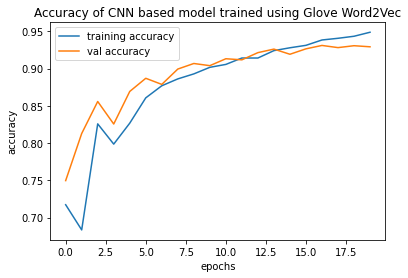

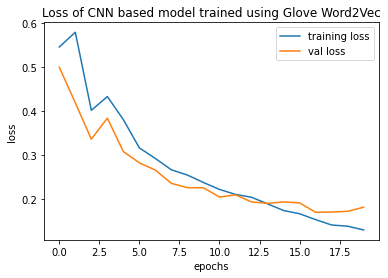

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy of CNN based model trained using Glove Word2Vec')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss of CNN based model trained using Glove Word2Vec')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [139]:
y_pred=model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [140]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
confusion_matrix(y_test,y_pred)

array([[2938,  169],
       [ 219, 2160]])

In [141]:
print('Accuracy: ',accuracy_score(y_test,y_pred))
print('AUC Score: ',roc_auc_score(y_test,y_pred))

Accuracy:  0.9292745169522421
AUC Score:  0.9267756045312805
